# Facebook Ads Clustering with K-means

_Using K-means to understand better facebook ads conversion data in the beauty treatment industry_

---

## Contents


#### 1) Business Problem
#### 2) Data Understanding

    2.1) Import libraries
    
    2.2) Connect to the meta marketing api
    
    2.3) Exploratory data analysis
    
#### 3) Data preparation
#### 4) Modelling and evaluation






---

## 1) Business Problem

* When do ads work better in terms of volume of conversions (Chat messages triggered by ads) and cost per conversion? What are the characteristics in terms of age, gender, service offered and season of the year of the best and the worst performing ads? In this notebook we will perform clustering to attempt to solve this problem.

---

## 2) Data understanding



### 2.1 Import libraries

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 2.2 Connect to the meta marketing api

The code below extracts 3 years of real data from a facebook ads account, removes pagination and displays a dataframe. The data is broken down by month, campaign name, age and gender, and also contains the columns objective (campaign objective) and actions (conversions). The following video contains an explanation of how to connect to the meta marketing api using an access token:
https://www.youtube.com/watch?v=to4uTxSNo6Q&t=385s

In [ ]:
url = ("https://graph.facebook.com/v17.0/XXXXXXX/insights"
       "?date_preset=maximum"
       "&level=campaign"
       "&fields=campaign_name,spend,objective,actions"
       "&time_increment=monthly"
       "&breakdowns=age,gender"
       "&access_token=XXXXXXXXX")

# Fetch JSON data from the URL
response = requests.get(url)
data = response.json()

# Extract all data and pagination information
all_data = data.get('data', [])
while 'paging' in data and 'next' in data['paging']:
    response = requests.get(data['paging']['next'])
    data = response.json()
    all_data.extend(data.get('data', []))

# Create a Pandas DataFrame
df = pd.DataFrame(all_data)

# Display the DataFrame
df.head()

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,751.6,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,25-34,female
1,Mensajes hyper,1241.07,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,35-44,female
2,Mensajes hyper,1613.16,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,45-54,female
3,Mensajes hyper,738.73,MESSAGES,"[{'action_type': 'post', 'value': '2'}, {'acti...",2020-08-05,2020-08-31,55-64,female
4,Mensajes Coolsculpting,46.36,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-08-05,2020-08-31,18-24,female


#### 2.3 Exploratory data analysis

Data types in the data frame:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 0 to 2855
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_name  2856 non-null   object
 1   spend          2856 non-null   object
 2   objective      2856 non-null   object
 3   actions        2568 non-null   object
 4   date_start     2856 non-null   object
 5   date_stop      2856 non-null   object
 6   age            2856 non-null   object
 7   gender         2856 non-null   object
dtypes: object(8)
memory usage: 178.6+ KB


Number of rows and columns:

In [ ]:
df.shape

(2856, 8)

Remove rows where the campaign objective is not messages. This is because we are only interested in predicting conversions for campaigns that aim to generate a chat message.

In [ ]:
filtered_df = df[df['objective'] == 'MESSAGES']

# Display the filtered DataFrame
filtered_df.head()

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,751.6,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,25-34,female
1,Mensajes hyper,1241.07,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,35-44,female
2,Mensajes hyper,1613.16,MESSAGES,"[{'action_type': 'onsite_web_add_to_cart', 'va...",2020-08-05,2020-08-31,45-54,female
3,Mensajes hyper,738.73,MESSAGES,"[{'action_type': 'post', 'value': '2'}, {'acti...",2020-08-05,2020-08-31,55-64,female
4,Mensajes Coolsculpting,46.36,MESSAGES,[{'action_type': 'onsite_web_app_view_content'...,2020-08-05,2020-08-31,18-24,female


Number of rows and columns (Only using rows with a "messages" campaign objective)

In [ ]:
filtered_df.shape

(1399, 8)

Below the distribution of rows for gender can be observed. There are a lot of unknown values!

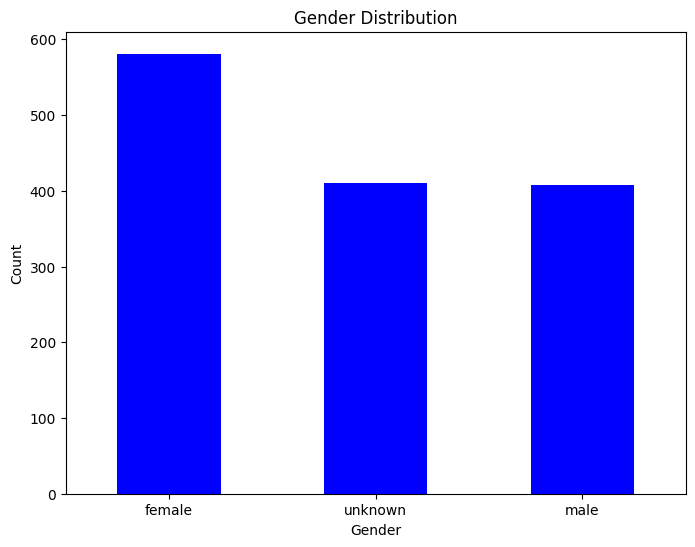

In [ ]:
# Count the occurrences of each gender value
gender_counts = filtered_df['gender'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

We will remove those rows where gender is unknown to work only with complete data.

In [ ]:
# Remove rows where the "gender" column is 'unknown'
filtered_df = filtered_df[filtered_df['gender'] != 'unknown']

Below the distribution of rows for age can be observed.

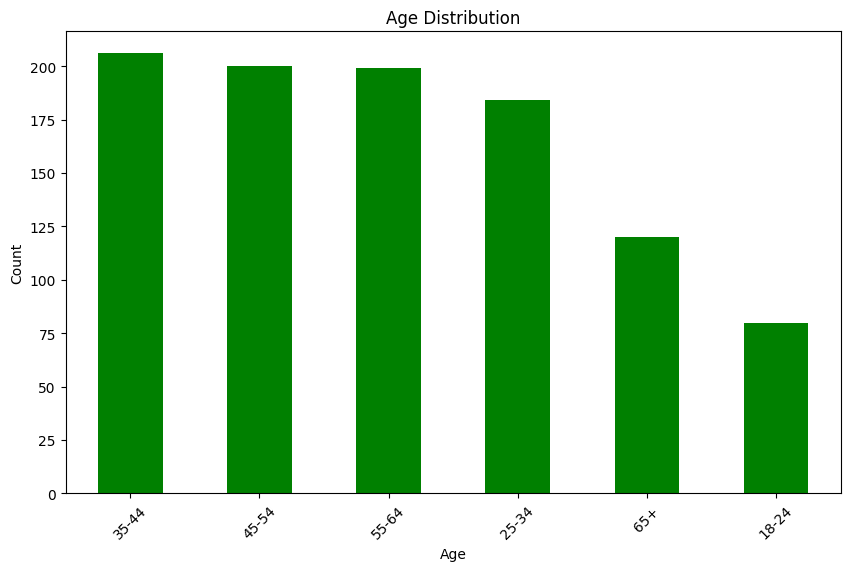

In [ ]:
# Count the occurrences of each age value
age_counts = filtered_df['age'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='green')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Below the distribution of campaign names is shown. Most campaigns have on the name the cosmetic treatment which is being offered. This information could be used later for feature extraction.

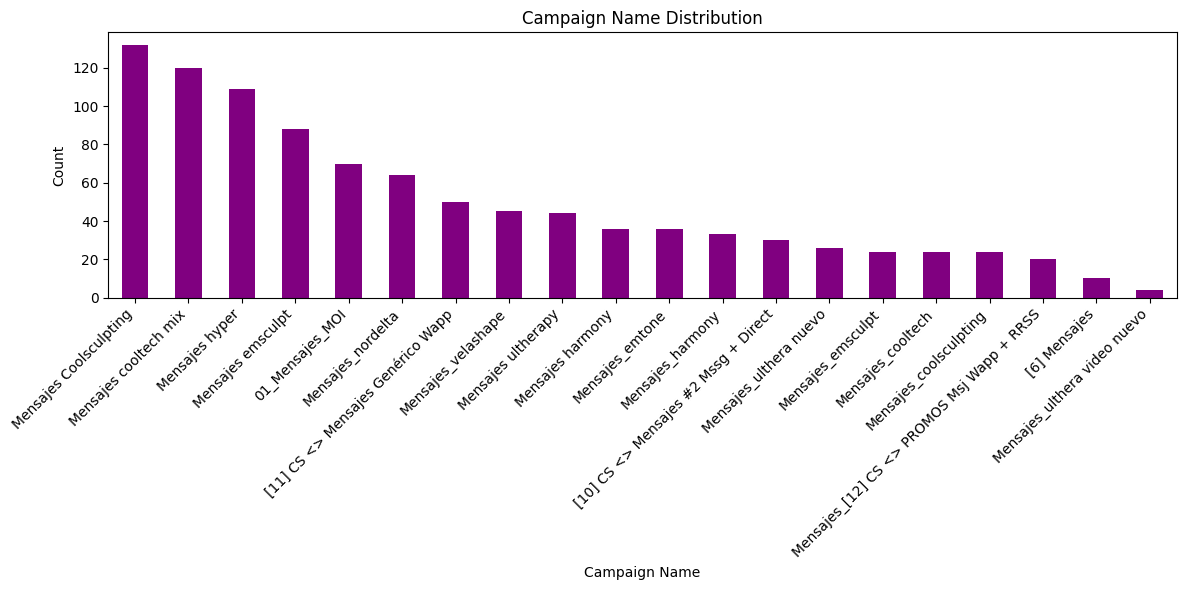

In [ ]:
# Count the occurrences of each campaign name
campaign_counts = filtered_df['campaign_name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
campaign_counts.plot(kind='bar', color='purple')
plt.title('Campaign Name Distribution')
plt.xlabel('Campaign Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We will change the data type of the column 'spend' from string to numeric

In [ ]:
# Convert 'spend' column to numeric
filtered_df['spend'] = pd.to_numeric(filtered_df['spend'], errors='coerce')

The following histogram shows how the distribution of spend is skewed to the right:

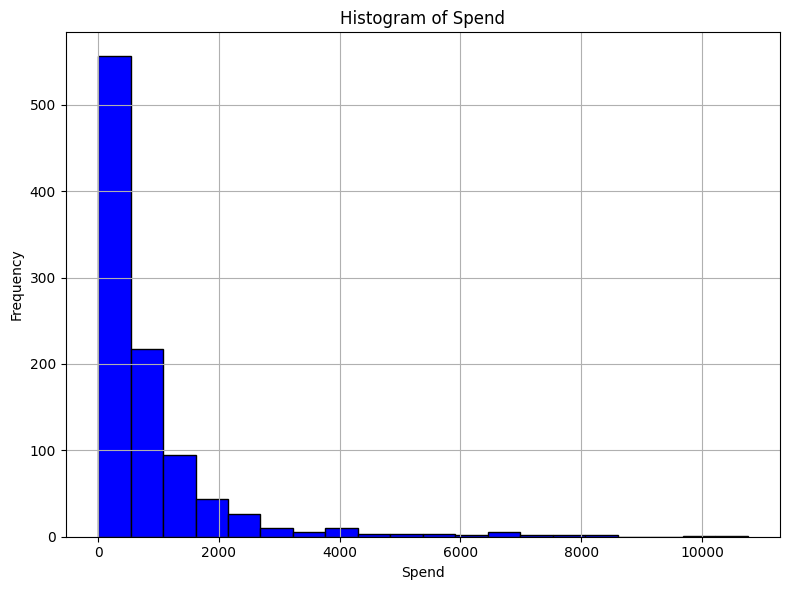

In [ ]:
# Create a histogram for the 'spend' column
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['spend'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Spend')
plt.xlabel('Spend')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

There are 5 rows with 0 spend.

In [ ]:
spend_value_counts = filtered_df['spend'].value_counts()
spend_value_counts

0.000000      5
18.250000     2
294.320000    1
699.430000    1
26.510000     1
             ..
504.945370    1
101.283229    1
787.643940    1
74.739279     1
760.610000    1
Name: spend, Length: 984, dtype: int64

Below we will see how a value of the actions column looks like:

In [ ]:
# Get the value of the first row in the 'actions' column
first_actions_value = filtered_df.loc[0, 'actions']

print("Value of the first row in 'actions' column:", first_actions_value)

Value of the first row in 'actions' column: [{'action_type': 'onsite_web_add_to_cart', 'value': '1'}, {'action_type': 'add_to_cart', 'value': '1'}, {'action_type': 'onsite_web_app_view_content', 'value': '41'}, {'action_type': 'onsite_conversion.messaging_first_reply', 'value': '12'}, {'action_type': 'post_engagement', 'value': '1268'}, {'action_type': 'onsite_conversion.view_content', 'value': '5'}, {'action_type': 'page_engagement', 'value': '1268'}, {'action_type': 'comment', 'value': '10'}, {'action_type': 'omni_add_to_cart', 'value': '1'}, {'action_type': 'view_content', 'value': '36'}, {'action_type': 'landing_page_view', 'value': '16'}, {'action_type': 'onsite_app_view_content', 'value': '5'}, {'action_type': 'onsite_web_app_add_to_cart', 'value': '1'}, {'action_type': 'onsite_web_view_content', 'value': '41'}, {'action_type': 'search', 'value': '2'}, {'action_type': 'onsite_conversion.messaging_conversation_started_7d', 'value': '14'}, {'action_type': 'offsite_conversion.fb_pix

Instead of having values in this format we want the numerical value from onsite_conversion.messaging_conversation_started_7d, which is the type of conversion (Chat messages thanks to ads, that we want to measure)

In [ ]:
def process_actions(actions_list):
    if isinstance(actions_list, list):
        for action in actions_list:
            if 'action_type' in action and action['action_type'] == 'onsite_conversion.messaging_conversation_started_7d':
                return int(action['value'])
    return 0

# Apply the custom function to the 'actions' column
filtered_df['actions'] = filtered_df['actions'].apply(process_actions)

The dataframe below shows how our function worked.

In [ ]:
filtered_df

,campaign_name,spend,objective,actions,date_start,date_stop,age,gender
0,Mensajes hyper,751.60,MESSAGES,14,2020-08-05,2020-08-31,25-34,female
1,Mensajes hyper,1241.07,MESSAGES,33,2020-08-05,2020-08-31,35-44,female
2,Mensajes hyper,1613.16,MESSAGES,32,2020-08-05,2020-08-31,45-54,female
3,Mensajes hyper,738.73,MESSAGES,15,2020-08-05,2020-08-31,55-64,female
4,Mensajes Coolsculpting,46.36,MESSAGES,3,2020-08-05,2020-08-31,18-24,female
...,...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,MESSAGES,6,2022-09-01,2022-09-30,45-54,male
2135,01_Mensajes_MOI,5797.93,MESSAGES,13,2022-09-01,2022-09-30,55-64,female
2136,01_Mensajes_MOI,1195.72,MESSAGES,3,2022-09-01,2022-09-30,55-64,male
2138,01_Mensajes_MOI,4207.56,MESSAGES,5,2022-09-01,2022-09-30,65+,female


We will also change the actions column to numeric format

In [ ]:
# Convert 'actions' column to numeric
filtered_df['actions'] = pd.to_numeric(filtered_df['actions'], errors='coerce')

We can see how the actions column is skewed to the right

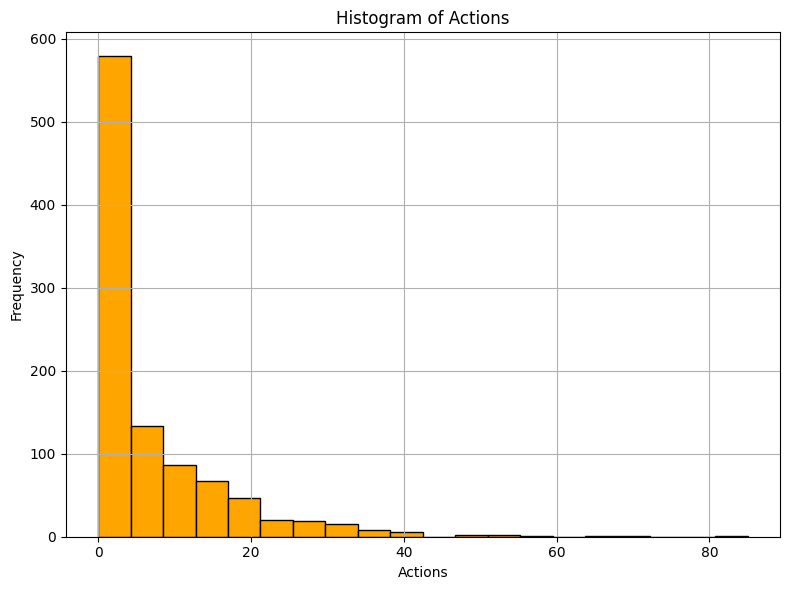

In [ ]:
# Create a histogram for the 'actions' column
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['actions'], bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Actions')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

Next we change the name of the dataframe for convenience

In [ ]:
df = filtered_df

Currently we have two columns with start date and end date. We will just keep one column, change it to date format, and show only the month number.

In [ ]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_stop'] = pd.to_datetime(df['date_stop'])

# Extract the month from 'date_start' and create a new column
df['start_month'] = df['date_start'].dt.month

# Drop the original 'date_start' and 'date_stop' columns
df.drop(['date_start', 'date_stop'], axis=1, inplace=True)
df

,campaign_name,spend,objective,actions,age,gender,start_month
0,Mensajes hyper,751.60,MESSAGES,14,25-34,female,8
1,Mensajes hyper,1241.07,MESSAGES,33,35-44,female,8
2,Mensajes hyper,1613.16,MESSAGES,32,45-54,female,8
3,Mensajes hyper,738.73,MESSAGES,15,55-64,female,8
4,Mensajes Coolsculpting,46.36,MESSAGES,3,18-24,female,8
...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,MESSAGES,6,45-54,male,9
2135,01_Mensajes_MOI,5797.93,MESSAGES,13,55-64,female,9
2136,01_Mensajes_MOI,1195.72,MESSAGES,3,55-64,male,9
2138,01_Mensajes_MOI,4207.56,MESSAGES,5,65+,female,9


Everything seems to be ok for the months distribution. There is no month with missing values.

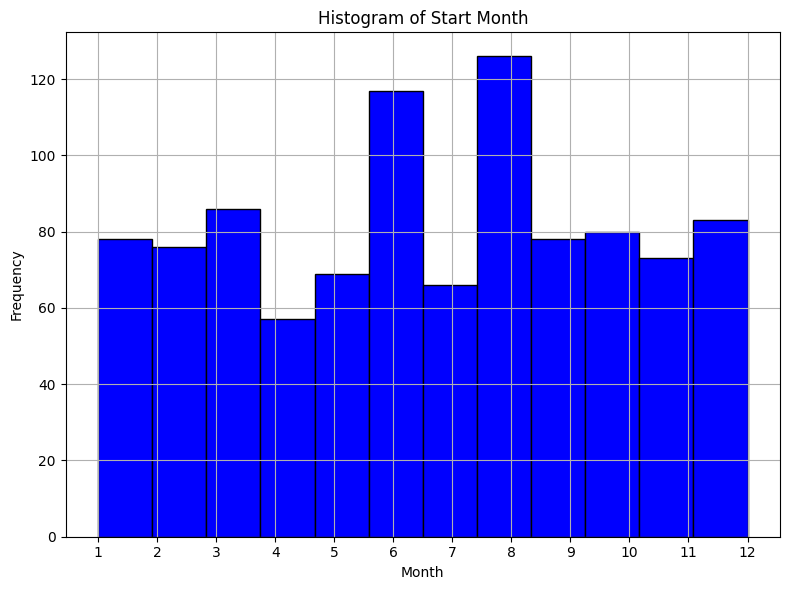

In [ ]:
# Create a histogram for the 'start_month' column
plt.figure(figsize=(8, 6))
plt.hist(df['start_month'], bins=12, color='blue', edgecolor='black')
plt.title('Histogram of Start Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13))  # Setting x-axis ticks to represent months
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

In [ ]:
# Get value counts for the 'start_month' column
start_month_value_counts = df['start_month'].value_counts()

print(start_month_value_counts)

8     126
6     117
3      86
12     83
10     80
9      78
1      78
2      76
11     73
5      69
7      66
4      57
Name: start_month, dtype: int64


It can be observed how as the amount spent increases, the amount of conversions tends to increase.

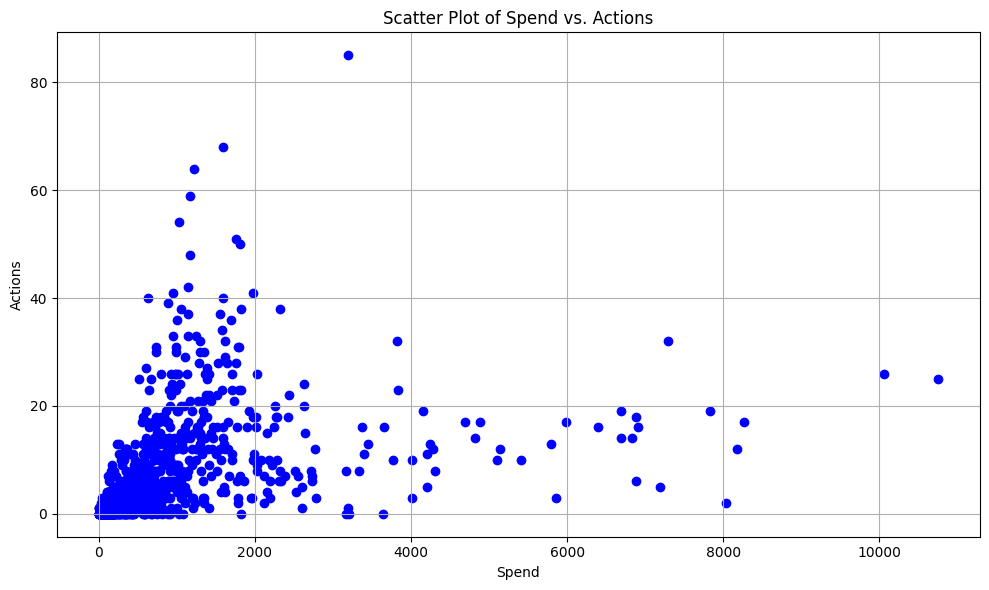

In [ ]:
# Assuming 'df' is your DataFrame

# Create a scatter plot for 'spend' and 'actions'
plt.figure(figsize=(10, 6))
plt.scatter(df['spend'], df['actions'], color='blue', marker='o')
plt.title('Scatter Plot of Spend vs. Actions')
plt.xlabel('Spend')
plt.ylabel('Actions')
plt.grid(True)
plt.tight_layout()  # Adjusts layout for better visualization
plt.show()

---

## 3) Data preparation



We will perform below a one-hot encoding for 'gender' columns.

In [ ]:
age_counts = df['age'].value_counts()

# Get value counts for the "gender" column
gender_counts = df['gender'].value_counts()

# Display the value counts
print("Value Counts for Age:")
print(age_counts)
print("\nValue Counts for Gender:")
print(gender_counts)

Value Counts for Age:
35-44    206
45-54    200
55-64    199
25-34    184
65+      120
18-24     80
Name: age, dtype: int64

Value Counts for Gender:
female    581
male      408
Name: gender, dtype: int64


In [ ]:
# Perform one-hot encoding for 'gender' columns
df = pd.get_dummies(df, columns=['gender'])

In [ ]:
df

,campaign_name,spend,objective,actions,age,start_month,gender_female,gender_male
0,Mensajes hyper,751.60,MESSAGES,14,25-34,8,1,0
1,Mensajes hyper,1241.07,MESSAGES,33,35-44,8,1,0
2,Mensajes hyper,1613.16,MESSAGES,32,45-54,8,1,0
3,Mensajes hyper,738.73,MESSAGES,15,55-64,8,1,0
4,Mensajes Coolsculpting,46.36,MESSAGES,3,18-24,8,1,0
...,...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,MESSAGES,6,45-54,9,0,1
2135,01_Mensajes_MOI,5797.93,MESSAGES,13,55-64,9,1,0
2136,01_Mensajes_MOI,1195.72,MESSAGES,3,55-64,9,0,1
2138,01_Mensajes_MOI,4207.56,MESSAGES,5,65+,9,1,0


We will drop the objective column because it has no variability.

In [ ]:
df = df.drop(columns=['objective'])


Since the beauty treatments industry is seasonal, we will also include seasons for each month:

In [ ]:
def map_to_season(month):
    if month in [1, 2, 3]:
        return "summer"
    elif month in [4, 5, 6]:
        return "autumn"
    elif month in [7, 8, 9]:
        return "winter"
    elif month in [10, 11, 12]:
        return "spring"
    else:
        return None

# Apply the function to create a new column "season"
df['season'] = df['start_month'].apply(map_to_season)

In [ ]:
df

,campaign_name,spend,actions,age,start_month,gender_female,gender_male,season
0,Mensajes hyper,751.60,14,25-34,8,1,0,winter
1,Mensajes hyper,1241.07,33,35-44,8,1,0,winter
2,Mensajes hyper,1613.16,32,45-54,8,1,0,winter
3,Mensajes hyper,738.73,15,55-64,8,1,0,winter
4,Mensajes Coolsculpting,46.36,3,18-24,8,1,0,winter
...,...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,6,45-54,9,0,1,winter
2135,01_Mensajes_MOI,5797.93,13,55-64,9,1,0,winter
2136,01_Mensajes_MOI,1195.72,3,55-64,9,0,1,winter
2138,01_Mensajes_MOI,4207.56,5,65+,9,1,0,winter


We will drop the column start_month and use only season to simplify our analysis

In [ ]:
df = df.drop(columns=['start_month'])
df

,campaign_name,spend,actions,age,gender_female,gender_male,season
0,Mensajes hyper,751.60,14,25-34,1,0,winter
1,Mensajes hyper,1241.07,33,35-44,1,0,winter
2,Mensajes hyper,1613.16,32,45-54,1,0,winter
3,Mensajes hyper,738.73,15,55-64,1,0,winter
4,Mensajes Coolsculpting,46.36,3,18-24,1,0,winter
...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,6,45-54,0,1,winter
2135,01_Mensajes_MOI,5797.93,13,55-64,1,0,winter
2136,01_Mensajes_MOI,1195.72,3,55-64,0,1,winter
2138,01_Mensajes_MOI,4207.56,5,65+,1,0,winter


Change the ages ranges from categorical to numerical (A value in the middle of the ranges will be assigned)

In [ ]:
age_mapping = {
    "18-24": 20,
    "25-34": 30,
    "35-44": 40,
    "45-54": 50,
    "55-64": 60,
    "65+": 70
}

df['age'] = df['age'].replace(age_mapping)

In [ ]:
df

,campaign_name,spend,actions,age,gender_female,gender_male,season
0,Mensajes hyper,751.60,14,30,1,0,winter
1,Mensajes hyper,1241.07,33,40,1,0,winter
2,Mensajes hyper,1613.16,32,50,1,0,winter
3,Mensajes hyper,738.73,15,60,1,0,winter
4,Mensajes Coolsculpting,46.36,3,20,1,0,winter
...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,6,50,0,1,winter
2135,01_Mensajes_MOI,5797.93,13,60,1,0,winter
2136,01_Mensajes_MOI,1195.72,3,60,0,1,winter
2138,01_Mensajes_MOI,4207.56,5,70,1,0,winter


Perform one hot encodings for season

In [ ]:
df = pd.get_dummies(df, columns=["season"], prefix=["season"])
df

,campaign_name,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter
0,Mensajes hyper,751.60,14,30,1,0,0,0,0,1
1,Mensajes hyper,1241.07,33,40,1,0,0,0,0,1
2,Mensajes hyper,1613.16,32,50,1,0,0,0,0,1
3,Mensajes hyper,738.73,15,60,1,0,0,0,0,1
4,Mensajes Coolsculpting,46.36,3,20,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2133,01_Mensajes_MOI,1860.40,6,50,0,1,0,0,0,1
2135,01_Mensajes_MOI,5797.93,13,60,1,0,0,0,0,1
2136,01_Mensajes_MOI,1195.72,3,60,0,1,0,0,0,1
2138,01_Mensajes_MOI,4207.56,5,70,1,0,0,0,0,1


Most of the campaign names contain the type of treatment offered in the ad in the campaign name. Hence, we will assign a category to the campaign, depending on the treatment offered.

In [ ]:
campaign_name_counts = df['campaign_name'].value_counts()

print(campaign_name_counts)

Mensajes Coolsculpting                        132
Mensajes cooltech mix                         120
Mensajes hyper                                109
Mensajes emsculpt                              88
01_Mensajes_MOI                                70
Mensajes_nordelta                              64
[11] CS <> Mensajes Genérico Wapp              50
Mensajes_velashape                             45
Mensajes ultherapy                             44
Mensajes harmony                               36
Mensajes_emtone                                36
Mensajes_harmony                               33
[10] CS <> Mensajes #2 Mssg + Direct           30
Mensajes_ulthera nuevo                         26
Mensajes_emsculpt                              24
Mensajes_cooltech                              24
Mensajes_coolsculpting                         24
Mensajes_[12] CS <> PROMOS Msj Wapp + RRSS     20
[6] Mensajes                                   10
Mensajes_ulthera video nuevo                    4


In [ ]:
# List of keywords and their replacements
replacements = {
    "coolsculpting": "coolsculpting",
    "cooltech": "cooltech",
    "hyper": "hyper",
    "emsculpt": "emsculpt",
    "harmony": "harmony",
    "ulthera": "ultherapy",
    "velashape": "velashape",
    "emtone": "emtone"
}

# Function to perform replacements
def replace_keywords(value):
    for keyword, replacement in replacements.items():
        if keyword in value.lower():
            return replacement
    return "other"

# Apply the function to create a new 'campaign_name_clean' column
df['campaign_name_clean'] = df['campaign_name'].apply(replace_keywords)

# Display value counts for the cleaned campaign names
campaign_name_clean_counts = df['campaign_name_clean'].value_counts()
print(campaign_name_clean_counts)

other            244
coolsculpting    156
cooltech         144
emsculpt         112
hyper            109
ultherapy         74
harmony           69
velashape         45
emtone            36
Name: campaign_name_clean, dtype: int64


We will remove rows with campain names that don't contain information about the service offered, to simplify our analysis:

In [ ]:
df = df[df['campaign_name_clean'] != 'other']
df

,campaign_name,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_name_clean
0,Mensajes hyper,751.600000,14,30,1,0,0,0,0,1,hyper
1,Mensajes hyper,1241.070000,33,40,1,0,0,0,0,1,hyper
2,Mensajes hyper,1613.160000,32,50,1,0,0,0,0,1,hyper
3,Mensajes hyper,738.730000,15,60,1,0,0,0,0,1,hyper
4,Mensajes Coolsculpting,46.360000,3,20,1,0,0,0,0,1,coolsculpting
...,...,...,...,...,...,...,...,...,...,...,...
1368,Mensajes_emtone,3836.803319,23,60,1,0,0,0,0,1,emtone
1369,Mensajes_emtone,1151.472105,10,70,1,0,0,0,0,1,emtone
1370,Mensajes hyper,0.000000,1,50,1,0,0,0,0,1,hyper
1371,Mensajes_ulthera nuevo,0.000000,1,40,0,1,0,0,0,1,ultherapy


We will also remove the campaign_name column

In [ ]:
df = df.drop(columns=['campaign_name'])
df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_name_clean
0,751.600000,14,30,1,0,0,0,0,1,hyper
1,1241.070000,33,40,1,0,0,0,0,1,hyper
2,1613.160000,32,50,1,0,0,0,0,1,hyper
3,738.730000,15,60,1,0,0,0,0,1,hyper
4,46.360000,3,20,1,0,0,0,0,1,coolsculpting
...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,emtone
1369,1151.472105,10,70,1,0,0,0,0,1,emtone
1370,0.000000,1,50,1,0,0,0,0,1,hyper
1371,0.000000,1,40,0,1,0,0,0,1,ultherapy


Perform one-hot encodings for campaign_name_clean

In [ ]:
encoded_campaigns = pd.get_dummies(df['campaign_name_clean'], prefix='campaign')

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_campaigns], axis=1)
df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_name_clean,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape
0,751.600000,14,30,1,0,0,0,0,1,hyper,0,0,0,0,0,1,0,0
1,1241.070000,33,40,1,0,0,0,0,1,hyper,0,0,0,0,0,1,0,0
2,1613.160000,32,50,1,0,0,0,0,1,hyper,0,0,0,0,0,1,0,0
3,738.730000,15,60,1,0,0,0,0,1,hyper,0,0,0,0,0,1,0,0
4,46.360000,3,20,1,0,0,0,0,1,coolsculpting,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,emtone,0,0,0,1,0,0,0,0
1369,1151.472105,10,70,1,0,0,0,0,1,emtone,0,0,0,1,0,0,0,0
1370,0.000000,1,50,1,0,0,0,0,1,hyper,0,0,0,0,0,1,0,0
1371,0.000000,1,40,0,1,0,0,0,1,ultherapy,0,0,0,0,0,0,1,0


Drop campaign_name_clean

In [ ]:
df = df.drop(columns=['campaign_name_clean'])
df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape
0,751.600000,14,30,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,1241.070000,33,40,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1613.160000,32,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,738.730000,15,60,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,46.360000,3,20,1,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,0,0,0,1,0,0,0,0
1369,1151.472105,10,70,1,0,0,0,0,1,0,0,0,1,0,0,0,0
1370,0.000000,1,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1371,0.000000,1,40,0,1,0,0,0,1,0,0,0,0,0,0,1,0


Check the datatypes of columns:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745 entries, 0 to 1372
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   spend                   745 non-null    float64
 1   actions                 745 non-null    int64  
 2   age                     745 non-null    int64  
 3   gender_female           745 non-null    uint8  
 4   gender_male             745 non-null    uint8  
 5   season_autumn           745 non-null    uint8  
 6   season_spring           745 non-null    uint8  
 7   season_summer           745 non-null    uint8  
 8   season_winter           745 non-null    uint8  
 9   campaign_coolsculpting  745 non-null    uint8  
 10  campaign_cooltech       745 non-null    uint8  
 11  campaign_emsculpt       745 non-null    uint8  
 12  campaign_emtone         745 non-null    uint8  
 13  campaign_harmony        745 non-null    uint8  
 14  campaign_hyper          745 non-null    u

In [ ]:
# Create the 'cpa' column
df['cpa'] = df['spend'] / df['actions']

df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape,cpa
0,751.600000,14,30,1,0,0,0,0,1,0,0,0,0,0,1,0,0,53.685714
1,1241.070000,33,40,1,0,0,0,0,1,0,0,0,0,0,1,0,0,37.608182
2,1613.160000,32,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,50.411250
3,738.730000,15,60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,49.248667
4,46.360000,3,20,1,0,0,0,0,1,1,0,0,0,0,0,0,0,15.453333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,0,0,0,1,0,0,0,0,166.817536
1369,1151.472105,10,70,1,0,0,0,0,1,0,0,0,1,0,0,0,0,115.147210
1370,0.000000,1,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.000000
1371,0.000000,1,40,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.000000


In [ ]:
# Replace NaN and inf values in the "cpa" column with 0
df['cpa'] = df['cpa'].replace([np.nan, np.inf, -np.inf], 0)

Create a correlation heatmap that displays correlations between features.

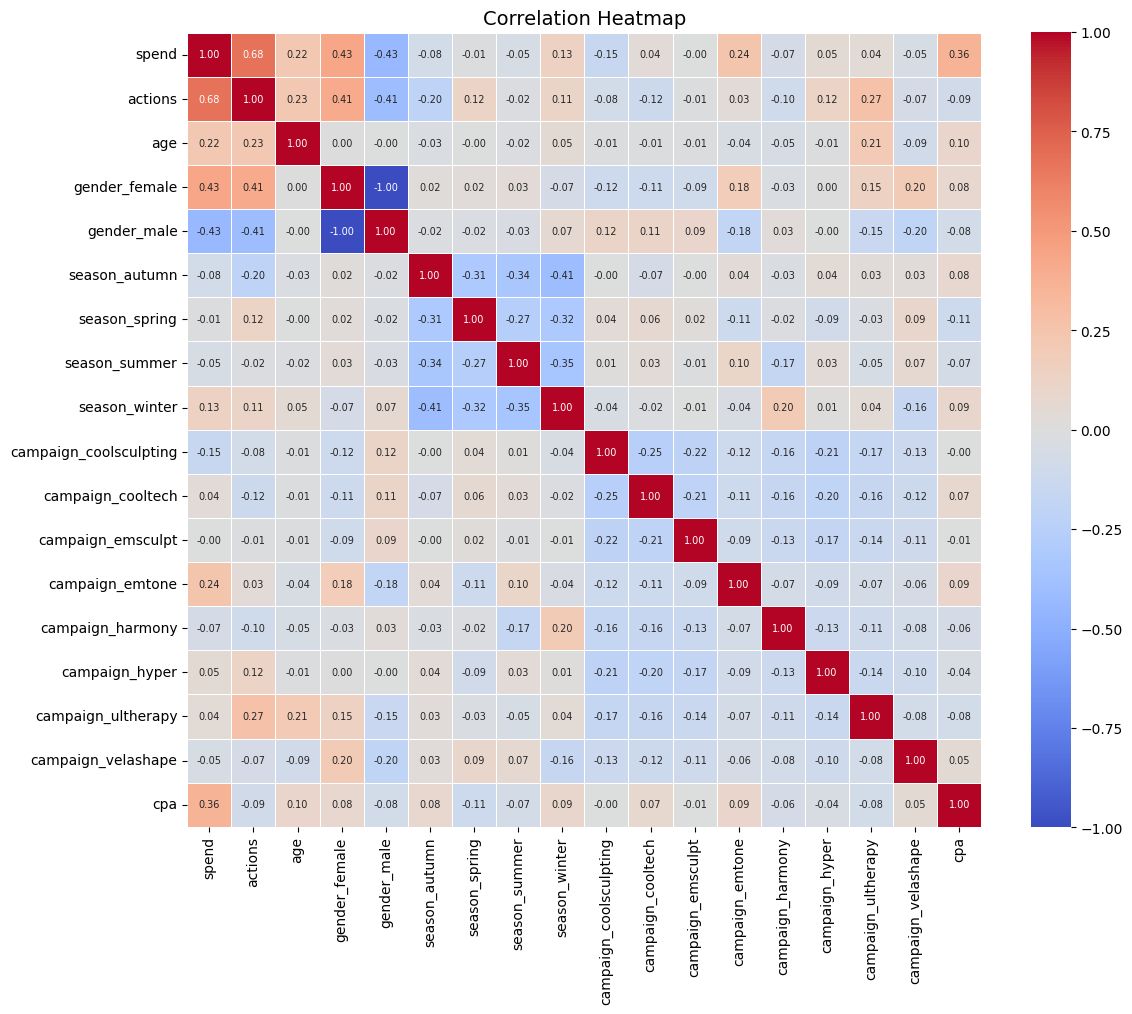

In [ ]:


# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a larger figure and adjust annotation font size and spacing
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
    annot_kws={"size": 7}, linewidths=0.5, square=True
)
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()  # Adjust layout to prevent cutoff labels
plt.show()


In [ ]:
df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape,cpa
0,751.600000,14,30,1,0,0,0,0,1,0,0,0,0,0,1,0,0,53.685714
1,1241.070000,33,40,1,0,0,0,0,1,0,0,0,0,0,1,0,0,37.608182
2,1613.160000,32,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,50.411250
3,738.730000,15,60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,49.248667
4,46.360000,3,20,1,0,0,0,0,1,1,0,0,0,0,0,0,0,15.453333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,0,0,0,1,0,0,0,0,166.817536
1369,1151.472105,10,70,1,0,0,0,0,1,0,0,0,1,0,0,0,0,115.147210
1370,0.000000,1,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.000000
1371,0.000000,1,40,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.000000


---

## 4) Modelling and evaluation

We will use kmeans to create 3 clusters, with 3 levels of performance (low, medium and high)

In [ ]:


kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df)

# Add the cluster labels to your DataFrame as a new column
df['Cluster'] = cluster_labels
df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape,cpa,Cluster
0,751.600000,14,30,1,0,0,0,0,1,0,0,0,0,0,1,0,0,53.685714,0
1,1241.070000,33,40,1,0,0,0,0,1,0,0,0,0,0,1,0,0,37.608182,0
2,1613.160000,32,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,50.411250,2
3,738.730000,15,60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,49.248667,0
4,46.360000,3,20,1,0,0,0,0,1,1,0,0,0,0,0,0,0,15.453333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,0,0,0,1,0,0,0,0,166.817536,2
1369,1151.472105,10,70,1,0,0,0,0,1,0,0,0,1,0,0,0,0,115.147210,0
1370,0.000000,1,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.000000,1
1371,0.000000,1,40,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.000000,1


The Silhouette Score assesses how well-separated the clusters are in the data. In this case, we have a value of 0.6091 which is acceptable.

In [ ]:
# Assuming 'df' is your DataFrame with the cluster labels in the 'Cluster' column
cluster_labels = df['Cluster']

# Calculate the silhouette score
silhouette_avg = silhouette_score(df, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6091571948515914


Below we will analyse the 3 clusters in terms of volume of conversions, amount spent and cpa (Cost per acquisition)

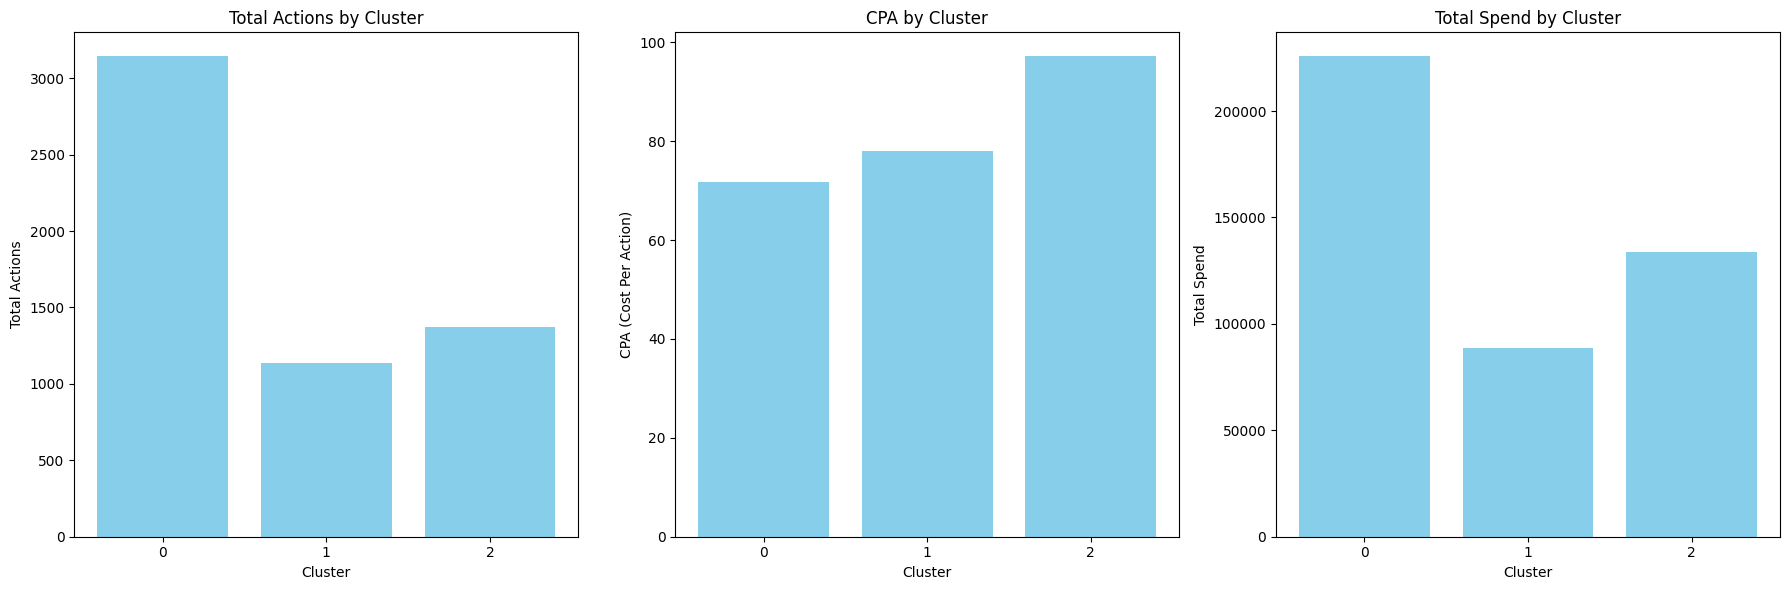

In [ ]:
# Group the data by the "Cluster" column and sum the "actions" within each cluster
cluster_actions = df.groupby('Cluster')['actions'].sum()

# Calculate the cpa (Cost Per Action) for each cluster
cpa_by_cluster = (df.groupby('Cluster')['spend'].sum() / df.groupby('Cluster')['actions'].sum()).reset_index()

# Calculate the total spend in each cluster
total_spend_by_cluster = df.groupby('Cluster')['spend'].sum()

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the Total Actions by Cluster
axs[0].bar(cluster_actions.index, cluster_actions, color='skyblue')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Total Actions')
axs[0].set_title('Total Actions by Cluster')
axs[0].set_xticks(cluster_actions.index)
axs[0].tick_params(axis='x', rotation=0)

# Plot the CPA by Cluster
axs[1].bar(cpa_by_cluster['Cluster'], cpa_by_cluster[0], color='skyblue')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('CPA (Cost Per Action)')
axs[1].set_title('CPA by Cluster')
axs[1].set_xticks(cpa_by_cluster['Cluster'])
axs[1].tick_params(axis='x', rotation=0)

# Plot the Total Spend by Cluster
axs[2].bar(total_spend_by_cluster.index, total_spend_by_cluster, color='skyblue')
axs[2].set_xlabel('Cluster')
axs[2].set_ylabel('Total Spend')
axs[2].set_title('Total Spend by Cluster')
axs[2].set_xticks(total_spend_by_cluster.index)
axs[2].tick_params(axis='x', rotation=0)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

In the graph above, we can see that cluster 0 is the best, because it has the highest number of conversions, and the lowest CPA. Cluster 1 is the second best, because it also has a relatively low cpa. Finally, Cluster 2 is the worst, because it has the highest cpa. Below we change the names of each cluster and assign them the values 'high_performance', 'medium_performance' and 'low_performance'

In [ ]:
# Assuming df is your DataFrame with the 'Cluster' column

# Create a dictionary to map cluster values to performance labels
cluster_mapping = {0: 'high_performance', 1: 'medium_performance', 2: 'low_performance'}

# Replace the values in the 'Cluster' column with the performance labels
df['Cluster'] = df['Cluster'].replace(cluster_mapping)

# Display the updated DataFrame
df

,spend,actions,age,gender_female,gender_male,season_autumn,season_spring,season_summer,season_winter,campaign_coolsculpting,campaign_cooltech,campaign_emsculpt,campaign_emtone,campaign_harmony,campaign_hyper,campaign_ultherapy,campaign_velashape,cpa,Cluster
0,751.600000,14,30,1,0,0,0,0,1,0,0,0,0,0,1,0,0,53.685714,high_performance
1,1241.070000,33,40,1,0,0,0,0,1,0,0,0,0,0,1,0,0,37.608182,high_performance
2,1613.160000,32,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,50.411250,low_performance
3,738.730000,15,60,1,0,0,0,0,1,0,0,0,0,0,1,0,0,49.248667,high_performance
4,46.360000,3,20,1,0,0,0,0,1,1,0,0,0,0,0,0,0,15.453333,medium_performance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,3836.803319,23,60,1,0,0,0,0,1,0,0,0,1,0,0,0,0,166.817536,low_performance
1369,1151.472105,10,70,1,0,0,0,0,1,0,0,0,1,0,0,0,0,115.147210,high_performance
1370,0.000000,1,50,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.000000,medium_performance
1371,0.000000,1,40,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.000000,medium_performance


The graphs below show gender for each cluster's amount spend. In the best and worst performing clusters, most of the budget was allocated to women. On the other hand, on the cluster of medium performance the budget was evenly distributed.

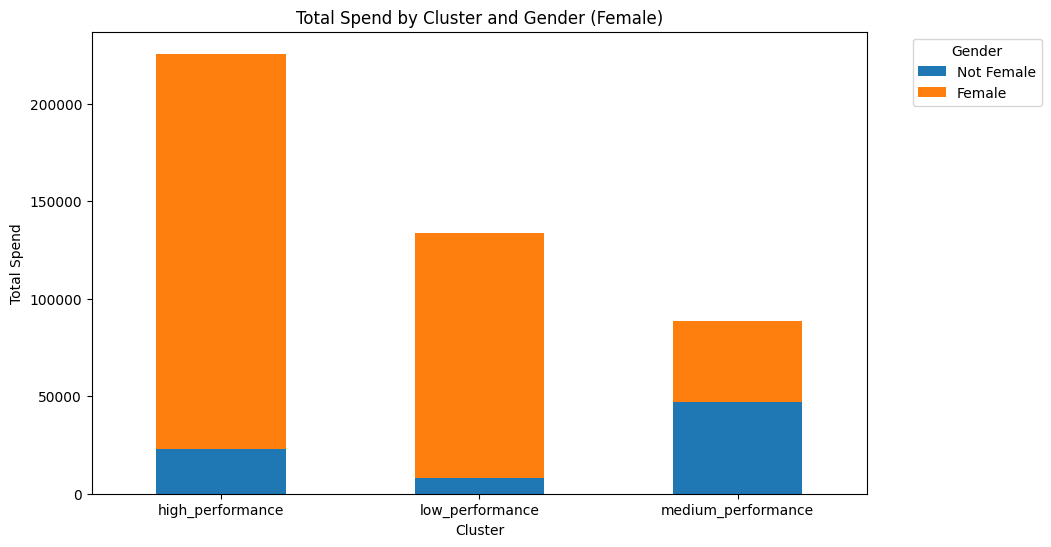

In [ ]:


# Assuming df is your DataFrame

# Group the data by 'Cluster' and 'gender_female' and calculate the sum of 'spend'
spend_by_cluster_gender = df.groupby(['Cluster', 'gender_female'])['spend'].sum().reset_index()

# Pivot the data to create a suitable format for plotting
spend_pivot = spend_by_cluster_gender.pivot(index='Cluster', columns='gender_female', values='spend')

# Create a stacked bar chart
ax = spend_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Total Spend')
plt.title('Total Spend by Cluster and Gender (Female)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Add a legend
plt.legend(title='Gender', labels=['Not Female', 'Female'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


Regarding age, on the best performing cluster the budget was relatively high and similar on the age range from 40 to 60.

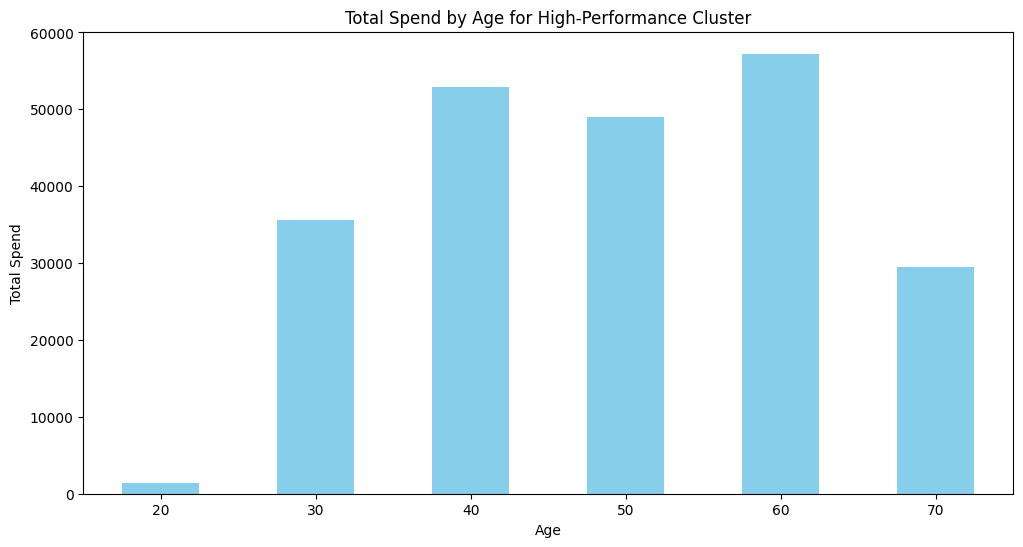

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'high_performance'
high_performance_df = df[df['Cluster'] == 'high_performance']

# Group the data by the 'age' column and calculate the sum of 'spend'
spend_by_age_high_performance = high_performance_df.groupby('age')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_age_high_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Age')
plt.ylabel('Total Spend')
plt.title('Total Spend by Age for High-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


Regarding age, on the medium performing cluster the budget was relatively high and similar on the age range from 30 to 60.

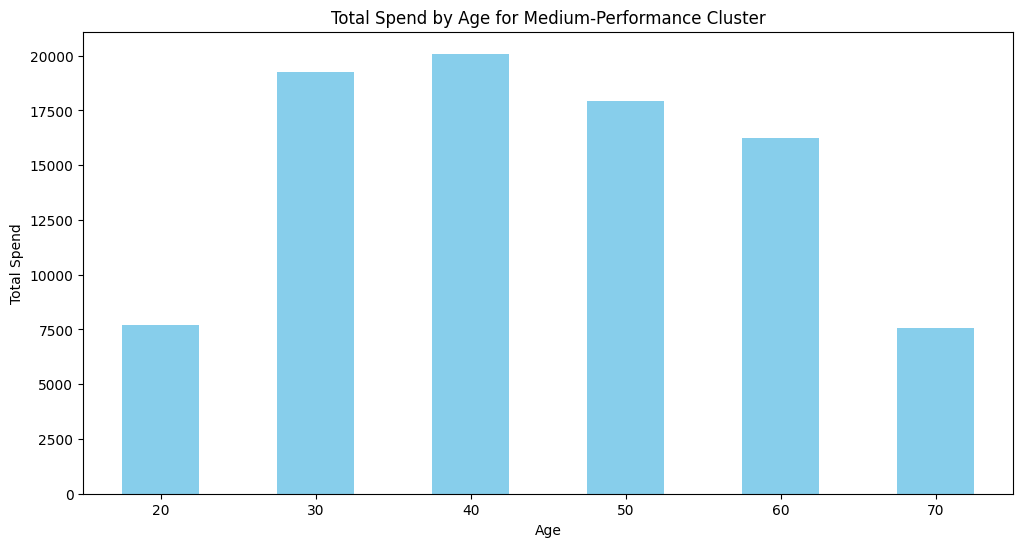

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'medium_performance'
medium_performance_df = df[df['Cluster'] == 'medium_performance']

# Group the data by the 'age' column and calculate the sum of 'spend'
spend_by_age_medium_performance = medium_performance_df.groupby('age')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_age_medium_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Age')
plt.ylabel('Total Spend')
plt.title('Total Spend by Age for Medium-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


On the worst performing cluster, the budget was significantly higher for the age range around 50, and lower for the others.

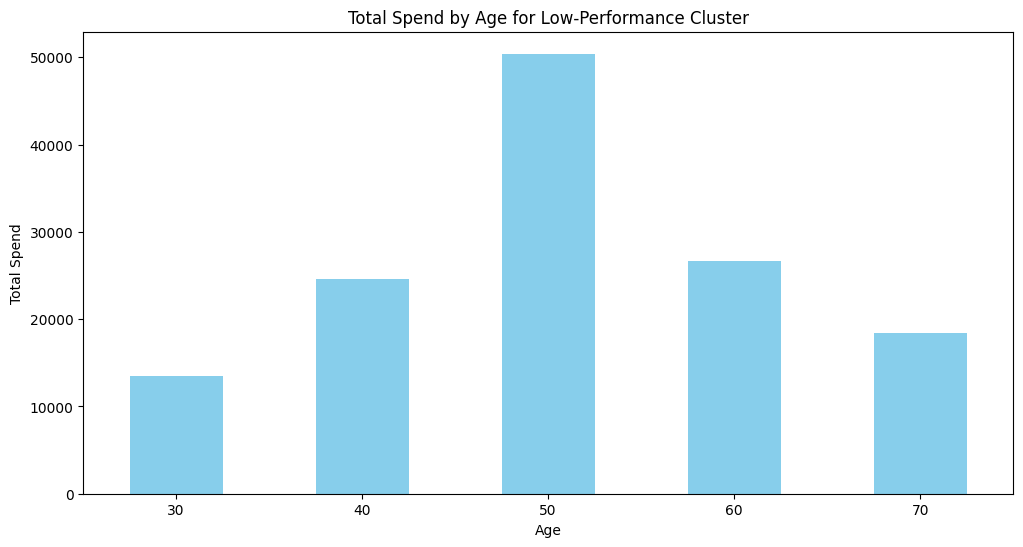

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'low_performance'
low_performance_df = df[df['Cluster'] == 'low_performance']

# Group the data by the 'age' column and calculate the sum of 'spend'
spend_by_age_low_performance = low_performance_df.groupby('age')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_age_low_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Age')
plt.ylabel('Total Spend')
plt.title('Total Spend by Age for Low-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


In the best performing cluster, a lower proportion of the total budget is allocated to winter (low season), in comparison with the other clusters.

<ipython-input-128-83bdd9307273>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_performance_df['season'] = high_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)


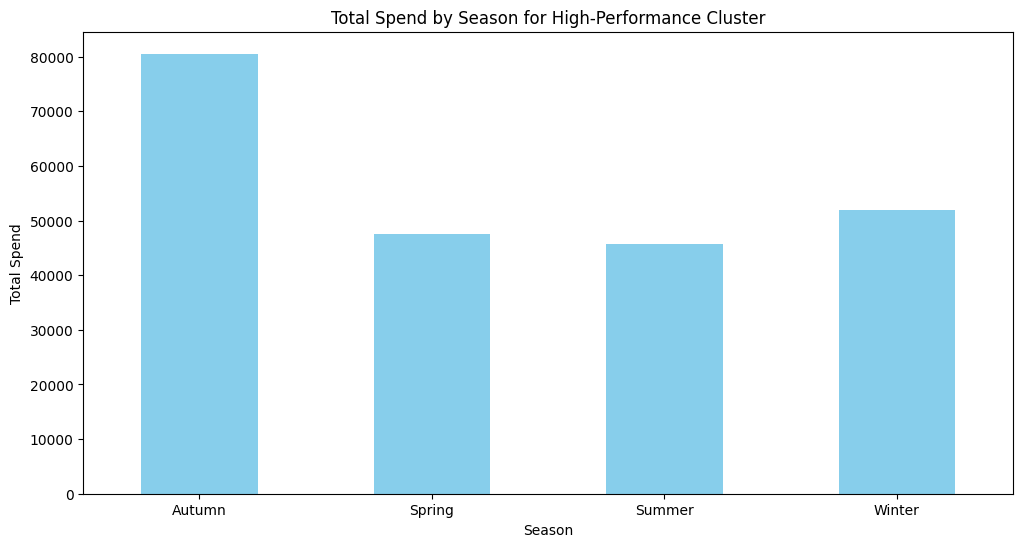

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'high_performance'
high_performance_df = df[df['Cluster'] == 'high_performance']

# Map column names to season names
season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
season_mapping = {
    tuple([0, 0, 0, 1]): 'Autumn',
    tuple([0, 0, 1, 0]): 'Spring',
    tuple([0, 1, 0, 0]): 'Summer',
    tuple([1, 0, 0, 0]): 'Winter'
}

# Replace the one-hot encoded values with season names
high_performance_df['season'] = high_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)

# Group the data by the 'season' column and calculate the sum of 'spend'
spend_by_season_high_performance = high_performance_df.groupby('season')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_season_high_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Season')
plt.ylabel('Total Spend')
plt.title('Total Spend by Season for High-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


<ipython-input-129-c2830772ea40>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_performance_df['season'] = medium_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)


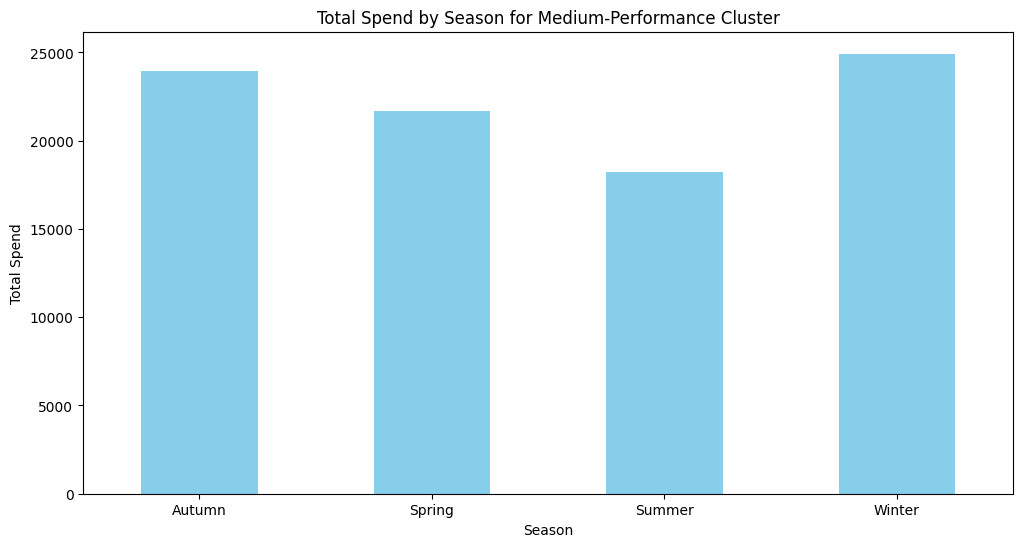

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'medium_performance'
medium_performance_df = df[df['Cluster'] == 'medium_performance']

# Map column names to season names
season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
season_mapping = {
    tuple([0, 0, 0, 1]): 'Autumn',
    tuple([0, 0, 1, 0]): 'Spring',
    tuple([0, 1, 0, 0]): 'Summer',
    tuple([1, 0, 0, 0]): 'Winter'
}

# Replace the one-hot encoded values with season names
medium_performance_df['season'] = medium_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)

# Group the data by the 'season' column and calculate the sum of 'spend'
spend_by_season_medium_performance = medium_performance_df.groupby('season')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_season_medium_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Season')
plt.ylabel('Total Spend')
plt.title('Total Spend by Season for Medium-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


<ipython-input-130-165a951347b1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_performance_df['season'] = low_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)


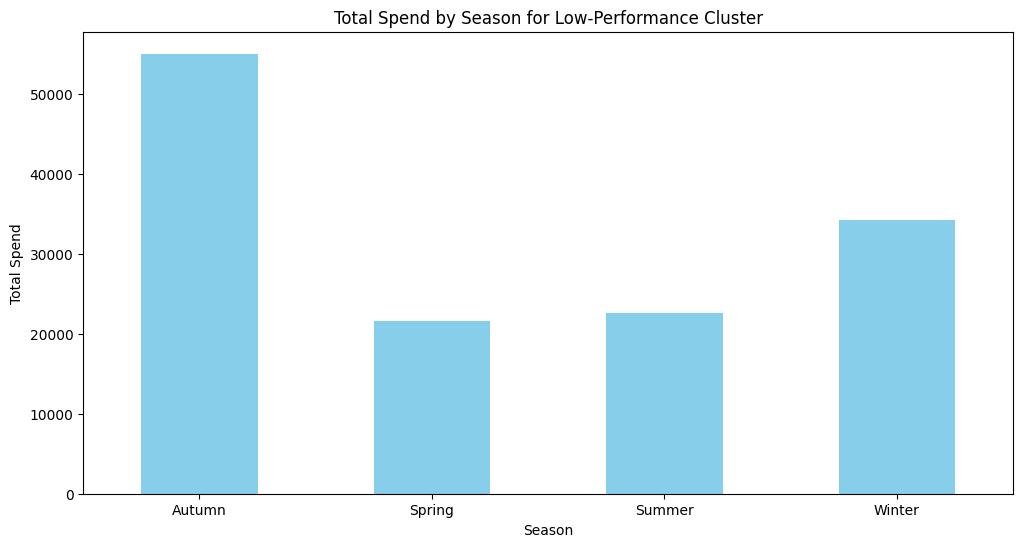

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'low_performance'
low_performance_df = df[df['Cluster'] == 'low_performance']

# Map column names to season names
season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
season_mapping = {
    tuple([0, 0, 0, 1]): 'Autumn',
    tuple([0, 0, 1, 0]): 'Spring',
    tuple([0, 1, 0, 0]): 'Summer',
    tuple([1, 0, 0, 0]): 'Winter'
}

# Replace the one-hot encoded values with season names
low_performance_df['season'] = low_performance_df[season_columns].apply(lambda x: season_mapping[tuple(x)], axis=1)

# Group the data by the 'season' column and calculate the sum of 'spend'
spend_by_season_low_performance = low_performance_df.groupby('season')['spend'].sum()

# Create a bar chart
plt.figure(figsize=(12, 6))
spend_by_season_low_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Season')
plt.ylabel('Total Spend')
plt.title('Total Spend by Season for Low-Performance Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

Regarding services offered, in the best performing cluster there is a relatively high investment in Coolsculpting, Cooltech, Emsculpt, Hyper and Ultherapy

<ipython-input-63-fa8d0377b33b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_performance_df['campaign'] = high_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)


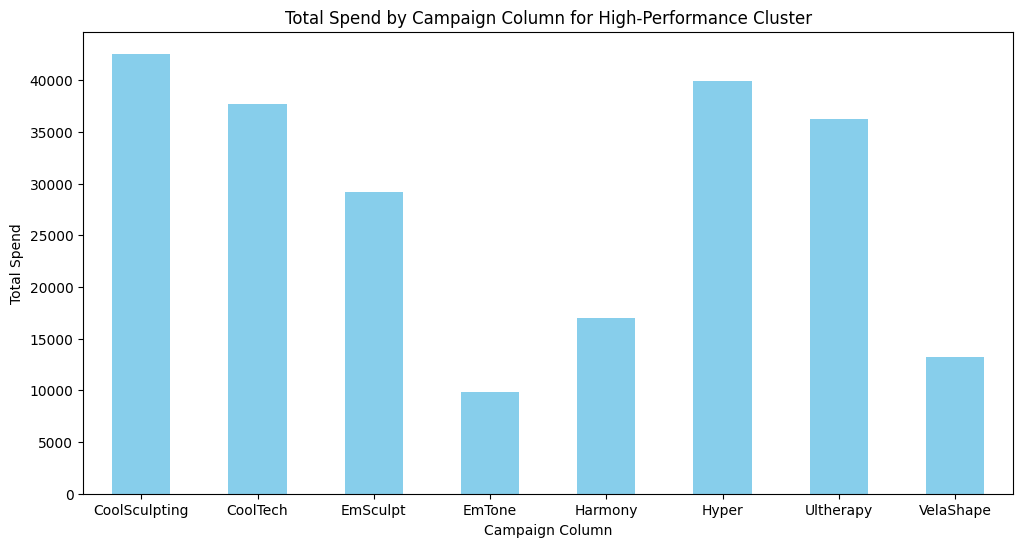

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'high_performance'
high_performance_df = df[df['Cluster'] == 'high_performance']

# Select the relevant columns (campaign columns)
campaign_columns = ['campaign_coolsculpting', 'campaign_cooltech', 'campaign_emsculpt', 'campaign_emtone', 'campaign_harmony', 'campaign_hyper', 'campaign_ultherapy', 'campaign_velashape']

# Map column names to campaign names
campaign_mapping = {
    tuple([1, 0, 0, 0, 0, 0, 0, 0]): 'CoolSculpting',
    tuple([0, 1, 0, 0, 0, 0, 0, 0]): 'CoolTech',
    tuple([0, 0, 1, 0, 0, 0, 0, 0]): 'EmSculpt',
    tuple([0, 0, 0, 1, 0, 0, 0, 0]): 'EmTone',
    tuple([0, 0, 0, 0, 1, 0, 0, 0]): 'Harmony',
    tuple([0, 0, 0, 0, 0, 1, 0, 0]): 'Hyper',
    tuple([0, 0, 0, 0, 0, 0, 1, 0]): 'Ultherapy',
    tuple([0, 0, 0, 0, 0, 0, 0, 1]): 'VelaShape'
}

# Replace the one-hot encoded values with campaign names
high_performance_df['campaign'] = high_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)

# Group the data by the 'campaign' column and calculate the sum of 'spend'
spend_by_campaign_high_performance = high_performance_df.groupby('campaign')['spend'].sum()

# Create a bar chart with x-axis labels as campaign names
plt.figure(figsize=(12, 6))
spend_by_campaign_high_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Campaign Column')
plt.ylabel('Total Spend')
plt.title('Total Spend by Campaign Column for High-Performance Cluster')
plt.xticks(rotation=0)  # Remove x-axis label rotation
plt.show()


In the medium performing cluster there is a relatively high investment in Coolsculpting, Cooltech, Emsculpt, while the other services are lower.

<ipython-input-64-9cd87b9271a3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_performance_df['campaign'] = medium_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)


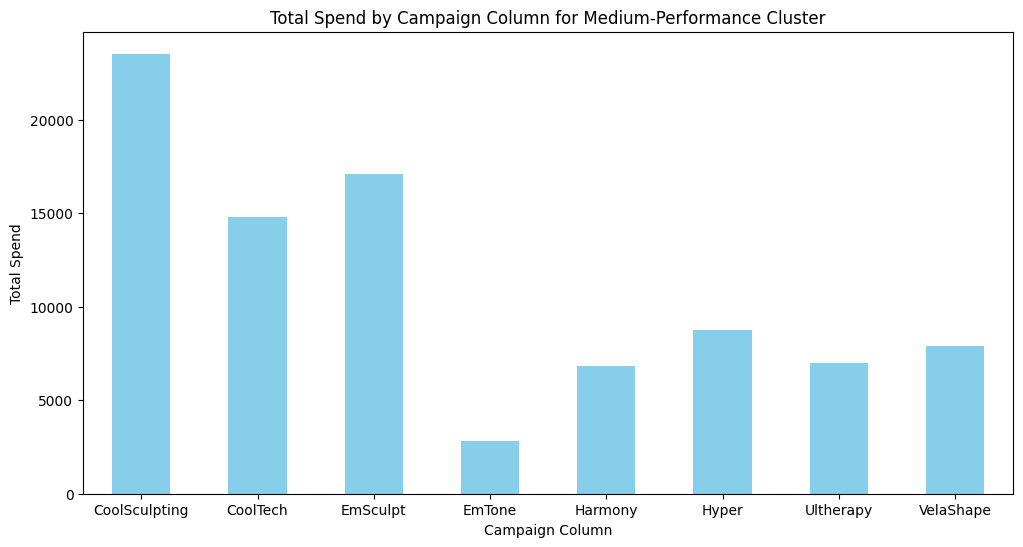

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'medium_performance' (change 'high_performance' to 'medium_performance')
medium_performance_df = df[df['Cluster'] == 'medium_performance']

# Select the relevant columns (campaign columns)
campaign_columns = ['campaign_coolsculpting', 'campaign_cooltech', 'campaign_emsculpt', 'campaign_emtone', 'campaign_harmony', 'campaign_hyper', 'campaign_ultherapy', 'campaign_velashape']

# Map column names to campaign names
campaign_mapping = {
    tuple([1, 0, 0, 0, 0, 0, 0, 0]): 'CoolSculpting',
    tuple([0, 1, 0, 0, 0, 0, 0, 0]): 'CoolTech',
    tuple([0, 0, 1, 0, 0, 0, 0, 0]): 'EmSculpt',
    tuple([0, 0, 0, 1, 0, 0, 0, 0]): 'EmTone',
    tuple([0, 0, 0, 0, 1, 0, 0, 0]): 'Harmony',
    tuple([0, 0, 0, 0, 0, 1, 0, 0]): 'Hyper',
    tuple([0, 0, 0, 0, 0, 0, 1, 0]): 'Ultherapy',
    tuple([0, 0, 0, 0, 0, 0, 0, 1]): 'VelaShape'
}

# Replace the one-hot encoded values with campaign names
medium_performance_df['campaign'] = medium_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)

# Group the data by the 'campaign' column and calculate the sum of 'spend'
spend_by_campaign_medium_performance = medium_performance_df.groupby('campaign')['spend'].sum()

# Create a bar chart with x-axis labels as campaign names
plt.figure(figsize=(12, 6))
spend_by_campaign_medium_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Campaign Column')
plt.ylabel('Total Spend')
plt.title('Total Spend by Campaign Column for Medium-Performance Cluster')  # Update the title
plt.xticks(rotation=0)  # Remove x-axis label rotation
plt.show()


On the worst performing cluster there is a relatively high investment in Coolsculpting, Cooltech, Emtone and Hyper, while the investments in other services is lower. Also, there is no investment in Coolscupting and Velashape.

<ipython-input-65-3769734ce825>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_performance_df['campaign'] = low_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)


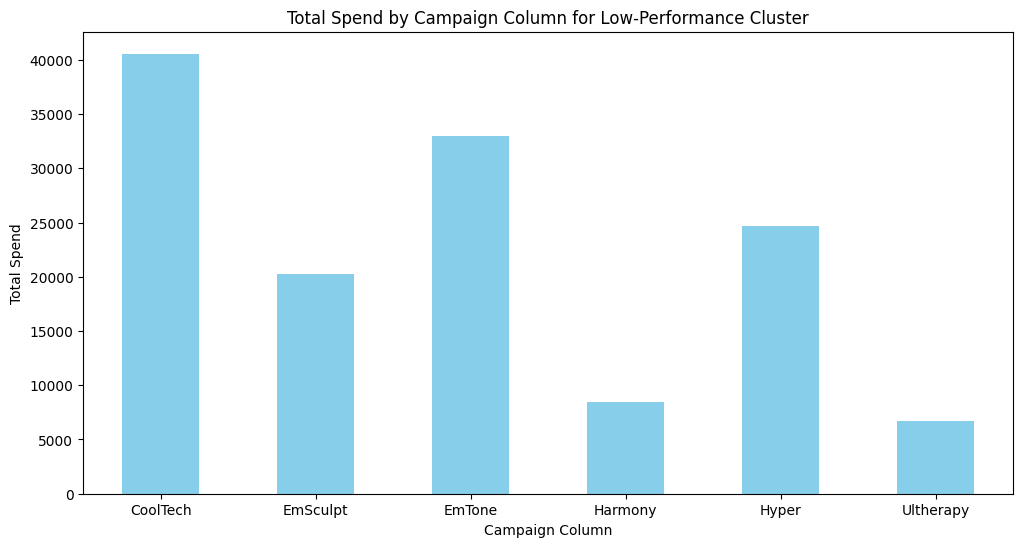

In [ ]:

# Assuming df is your DataFrame

# Filter rows where 'Cluster' is 'low_performance' (change 'high_performance' to 'low_performance')
low_performance_df = df[df['Cluster'] == 'low_performance']

# Select the relevant columns (campaign columns)
campaign_columns = ['campaign_coolsculpting', 'campaign_cooltech', 'campaign_emsculpt', 'campaign_emtone', 'campaign_harmony', 'campaign_hyper', 'campaign_ultherapy', 'campaign_velashape']

# Map column names to campaign names
campaign_mapping = {
    tuple([1, 0, 0, 0, 0, 0, 0, 0]): 'CoolSculpting',
    tuple([0, 1, 0, 0, 0, 0, 0, 0]): 'CoolTech',
    tuple([0, 0, 1, 0, 0, 0, 0, 0]): 'EmSculpt',
    tuple([0, 0, 0, 1, 0, 0, 0, 0]): 'EmTone',
    tuple([0, 0, 0, 0, 1, 0, 0, 0]): 'Harmony',
    tuple([0, 0, 0, 0, 0, 1, 0, 0]): 'Hyper',
    tuple([0, 0, 0, 0, 0, 0, 1, 0]): 'Ultherapy',
    tuple([0, 0, 0, 0, 0, 0, 0, 1]): 'VelaShape'
}

# Replace the one-hot encoded values with campaign names
low_performance_df['campaign'] = low_performance_df[campaign_columns].apply(lambda x: campaign_mapping[tuple(x)], axis=1)

# Group the data by the 'campaign' column and calculate the sum of 'spend'
spend_by_campaign_low_performance = low_performance_df.groupby('campaign')['spend'].sum()

# Create a bar chart with x-axis labels as campaign names
plt.figure(figsize=(12, 6))
spend_by_campaign_low_performance.plot(kind='bar', color='skyblue')
plt.xlabel('Campaign Column')
plt.ylabel('Total Spend')
plt.title('Total Spend by Campaign Column for Low-Performance Cluster')  # Update the title
plt.xticks(rotation=0)  # Remove x-axis label rotation
plt.show()


In conclusion, the best performing cluster is composed of a high percentage of the investment destined to women on an age range between 40 and 60, a lower investment in winter and higher investments on the services Coolsculpting, Cooltech, Emsculpt, Hyper and Ultherapy.